# GPT for Tabular Classification with SHAP Analysis

In [1]:
# Import Required Libraries
# Ensure TensorFlow and Transformers libraries are installed in your environment:
# pip install tensorflow numpy pandas scikit-learn matplotlib seaborn transformers shap
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import shap

2025-01-16 17:59:55.456759: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 17:59:55.457879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 17:59:55.484004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 17:59:55.484581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 17:59:55.971320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Step 1: Data Loading

In [2]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [3]:
# Drop 'difficulty_degree' column as it does not add value
# Remove 'difficulty_degree' column if it exists
if "difficulty_degree" in train.columns:
    del train["difficulty_degree"]

if "difficulty_degree" in test.columns:
    del test["difficulty_degree"]


# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert each row into a string format for tokenization
train_sequences = [" ".join(map(str, row)) for row in X_train]
test_sequences = [" ".join(map(str, row)) for row in X_test]



In [4]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_sequences, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_sequences, truncation=True, padding=True, max_length=128)

# Ensure labels are NumPy arrays and have the correct dtype
y_train = y_train.to_numpy().astype("float32")
y_test = y_test.to_numpy().astype("float32")

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), y_train
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings), y_test
)).batch(32)



2025-01-16 18:00:23.365962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 18:00:23.377478: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Step 3: Define the GPT Model

In [5]:
# Define the GPT Model
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# Compile the model with correct loss function
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

# Train the model
print("Training GPT Model...")
history = model.fit(train_dataset, epochs=3,    batch_size=64, validation_data=test_dataset)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Training GPT Model...
Epoch 1/3
3937/3937 [==============================] - 7057s 2s/step - loss: 0.0572 - accuracy: 0.9817 - val_loss: 0.8715 - val_accuracy: 0.8174
Epoch 2/3
3937/3937 [==============================] - 6907s 2s/step - loss: 0.0316 - accuracy: 0.9910 - val_loss: 1.0922 - val_accuracy: 0.8285
Epoch 3/3
3937/3937 [==============================] - 7380s 2s/step - loss: 0.0281 - accuracy: 0.9915 - val_loss: 1.4612 - val_accuracy: 0.8197


## Step 4: Train the Model

In [6]:
# Train the Model
print("Training GPT Model...")
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

Training GPT Model...
Epoch 1/3
3937/3937 [==============================] - 7456s 2s/step - loss: 0.0268 - accuracy: 0.9919 - val_loss: 1.3645 - val_accuracy: 0.8204
Epoch 2/3
3937/3937 [==============================] - 7458s 2s/step - loss: 0.0263 - accuracy: 0.9920 - val_loss: 1.4813 - val_accuracy: 0.7766
Epoch 3/3
3937/3937 [==============================] - 7455s 2s/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 1.3328 - val_accuracy: 0.8274


## Step 5: Evaluate the Model

In [7]:
# Evaluate on the test set
print("Evaluating GPT Model...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Evaluating GPT Model...
705/705 [==============================] - 392s 556ms/step - loss: 1.3328 - accuracy: 0.8274
Test Loss: 1.332787036895752, Test Accuracy: 0.8274042010307312


## Step 6: Visualizations

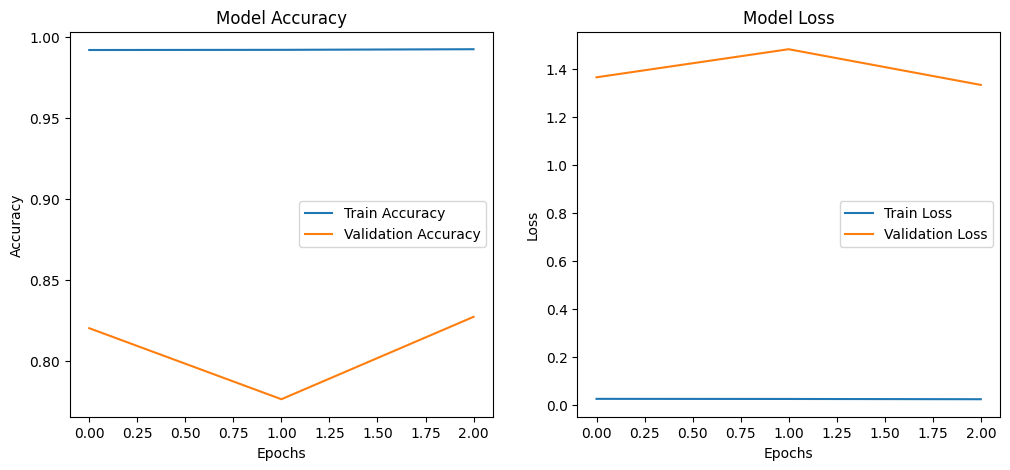

In [8]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 393s 556ms/step


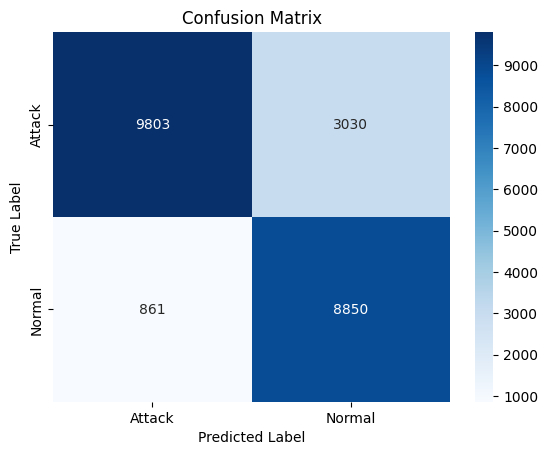

              precision    recall  f1-score   support

      Attack       0.92      0.76      0.83     12833
      Normal       0.74      0.91      0.82      9711

    accuracy                           0.83     22544
   macro avg       0.83      0.84      0.83     22544
weighted avg       0.84      0.83      0.83     22544



In [9]:
# Confusion Matrix
y_pred = tf.argmax(model.predict(test_dataset).logits, axis=1).numpy()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

705/705 [==============================] - 392s 556ms/step


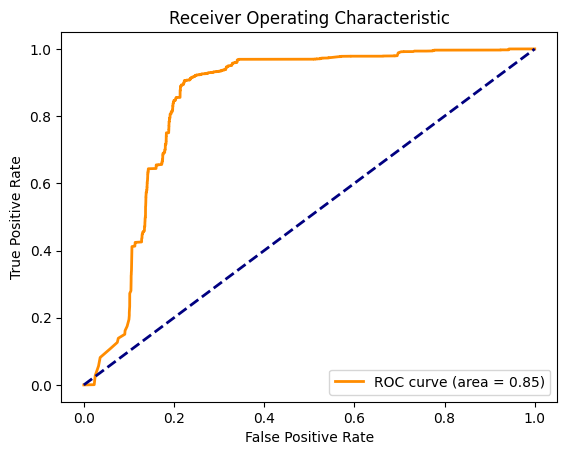

In [10]:
# ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_binarized = label_binarize(y_test, classes=[0, 1])
y_pred_proba = tf.nn.softmax(model.predict(test_dataset).logits)[:, 1].numpy()

fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Step 7: SHAP Analysis

In [11]:
# SHAP Analysis with Partial Data
import shap

# Select a subset of the data for SHAP analysis
subset_size = 100  # Adjust the number of samples as needed
X_test_subset = X_test[:subset_size]
x_train_subset = x_train[:subset_size]

# Initialize the SHAP explainer using the subset of training data
explainer = shap.Explainer(model.predict, x_train_subset)

# Generate SHAP values for the test subset
shap_values = explainer(X_test_subset)

# Define feature names explicitly as a list
feature_names = list(train.columns[:-1])  # Convert to list for SHAP compatibility

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
plt.savefig("visualization/shap_summary_plot.png")
plt.close()

# SHAP Decision Plot
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    feature_names=feature_names
)
plt.savefig("visualization/shap_decision_plot.png")
plt.close()

# SHAP Force Plot (Single Instance)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    X_test_subset[0], 
    feature_names=feature_names, 
    matplotlib=True
)
shap.save_html(
    "visualization/shap_force_plot.html", 
    shap.force_plot(
        shap_values.base_values[0], 
        shap_values.values[0], 
        X_test_subset[0], 
        feature_names=feature_names
    )
)


NameError: name 'x_train' is not defined